# Canada Tax Revenue

Data from [here](https://www150.statcan.gc.ca/t1/tbl1/en/cv!recreate.action?pid=1010001701&selectedNodeIds=1D1,1D2,1D3,1D4,1D5,1D6,1D7,1D9,1D8,1D10,1D11,1D12,1D13,2D1,3D1,3D2,4D1,4D2,4D5,4D9,4D10,4D11,4D26,4D36,4D45,4D48,4D49,4D50,4D4,4D27,4D32,4D35,4D52,4D53,4D54,4D55,4D56,4D62,4D65,4D72,4D3All,4D3,4D51,4D130,4D81,4D82,4D85,4D86,4D90,4D91,4D95,4D98,4D102,4D103,4D106,4D108,4D109,4D114,4D118,4D119,4D122,4D125,4D89,4D107,4D87All,4D87,4D88,4D126,4D127,4D128,4D129,4D83All,4D83,4D84,&checkedLevels=3D1,3D2,3D3,3D4,3D5,3D6,&refPeriods=20070101,20170101&dimensionLayouts=layout3,layout3,layout3,layout3,layout2&vectorDisplay=true)

I also put the data [here on data.world](https://data.world/cottrell/canada/) but haven't done anything with it.

Skip to [the charts](#Charts)

# Data Prep

In [150]:
import pandas as pd
df_orig = pd.read_csv('10100017.csv')
df_orig.shape

(37180, 17)

In [15]:
df_orig.head().T

,0,1,2,3,4
REF_DATE,2007,2007,2007,2007,2007
GEO,Newfoundland and Labrador,Newfoundland and Labrador,Newfoundland and Labrador,Newfoundland and Labrador,Newfoundland and Labrador
DGUID,2016A000210,2016A000210,2016A000210,2016A000210,2016A000210
Public sector components,Provincial and territorial governments,Provincial and territorial governments,Provincial and territorial governments,Provincial and territorial governments,Provincial and territorial governments
Display value,Stocks,Stocks,Stocks,Stocks,Stocks
Statement of operations and balance sheet,Gross operating balance,Net operating balance,Revenue,Taxes,"Taxes on income, profits and capital gains"
UOM,Dollars,Dollars,Dollars,Dollars,Dollars
UOM_ID,81,81,81,81,81
SCALAR_FACTOR,millions,millions,millions,millions,millions
SCALAR_ID,6,6,6,6,6


In [62]:
todrop = list()
for k in df_orig:
    if df_orig[k].nunique() == 1:
        print('dropping {}'.format(k))
        todrop.append(k)
df = df_orig.drop(todrop, axis=1)

df = df.rename(columns={
    'Statement of operations and balance sheet': 'entry',
    'Display value': 'value_type'})
df.columns = [x.lower() for x in df.columns] # lower case is best case

df = df[df.value_type == 'Stocks']

dropping Public sector components
dropping UOM
dropping UOM_ID
dropping SCALAR_FACTOR
dropping SCALAR_ID
dropping STATUS
dropping DECIMALS


In [66]:
s = df.set_index(['ref_date', 'geo', 'entry']).value.dropna()
s.index.is_unique

True

In [67]:
s.head()

ref_date  geo                        entry                        
2007      Newfoundland and Labrador  Net financial worth             -6859.0
                                     Financial assets                 4745.0
                                     Currency and deposits, assets     642.0
                                     Debt securities, assets          1715.0
                                     Treasury bills, assets              0.0
Name: value, dtype: float64

In [88]:
d = s.unstack(['entry'])
d.head().T

ref_date                                               2007                                                                  
geo                                                 Alberta British Columbia Manitoba New Brunswick Newfoundland and Labrador
entry                                                                                                                        
Net financial worth                                 40407.0          -9920.0 -10258.0       -5372.0                   -6859.0
Financial assets                                    69817.0          41602.0  21619.0       13026.0                    4745.0
Currency and deposits, assets                         298.0           2579.0    633.0         193.0                     642.0
Debt securities, assets                             41411.0           3507.0   7874.0        9133.0                    1715.0
Treasury bills, assets                               2084.0              4.0     24.0           2.0                       0.0
Finance and other short-term paper, assets           8900.0            217.0    390.0         143.0                     832.0
Bonds, assets                                       30427.0           3286.0   7461.0        8986.0                     882.0
Loans, assets                                        2623.0           9857.0   8533.0         656.0                     204.0
Loans and advances, assets                           2618.0           9854.0   8386.0         656.0                     196.0
Mortgages, assets                                       5.0              4.0    147.0           0.0                       7.0
Equity and investment fund shares, assets           19661.0          20444.0   3422.0         962.0                    1447.0
Marketable shares                                   12807.0            271.0    697.0         561.0                     251.0
Non-marketable shares and other equity               4902.0           6135.0   2527.0         400.0                     758.0
Investment fund shares                               1952.0          14037.0    198.0           2.0                     438.0
Insurance and pension, assets                           0.0             73.0      5.0         458.0                       0.0
Other accounts receivable                            5824.0           5142.0   1152.0        1625.0                     737.0
Trade credits and advances, receivable                409.0            498.0     40.0          13.0                       9.0
Other receivable                                     5415.0           4643.0   1111.0        1612.0                     728.0
Monetary gold and special drawing rights (SDR),...      0.0              0.0      0.0           0.0                       0.0
Liabilities                                         29409.0          51521.0  31878.0       18399.0                   11602.0
Currency and deposits, liabilities                      0.0              0.0      0.0           0.0                       0.0
Debt securities, liabilities                         8085.0          37897.0  23096.0       15044.0                    8070.0
Treasury bills, liabilities                             0.0              0.0    650.0         712.0                     490.0
Finance and other short-term paper, liabilities        37.0           2416.0    199.0           0.0                       0.0
Saving bonds                                            0.0              0.0    374.0           0.0                       0.0
Bonds, liabilities                                   8048.0          35480.0  21873.0       14332.0                    7580.0
Loans, liabilities                                   1158.0           3206.0   1135.0         847.0                     505.0
Bank overdrafts                                         0.0           2698.0    116.0          48.0                      71.0
Loans and advances, liabilities                      1157.0            267.0    970.0         

In [83]:
comp_cols = [x for x in d.columns if 'compensation' in x.lower()]
comp_cols

["Contributions to workers' compensation boards",
 'Compensation of employees',
 "Workers' compensation benefits",
 'Memorandum items, capitalized research and development compensation of employees']

In [85]:
rev_cols = [x for x in d.columns if 'rev' in x.lower()]
rev_cols

['Revenue',
 'Grants, revenue',
 'Other revenue',
 'Interest revenue',
 'Miscellaneous revenue']

# Charts

In [115]:
import seaborn as sns

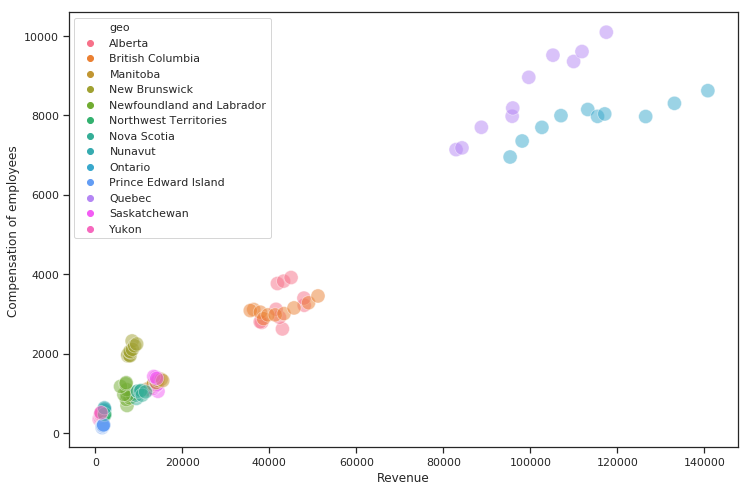

In [165]:
%matplotlib inline
dd = d.reset_index()
dd['% Revenue to Employees'] = dd['Compensation of employees'] / dd['Revenue']
from pylab import *

figure(figsize=(12, 8))
ax = sns.scatterplot(x="Revenue", y="Compensation of employees", hue="geo", data=dd, s=200, alpha=0.5)

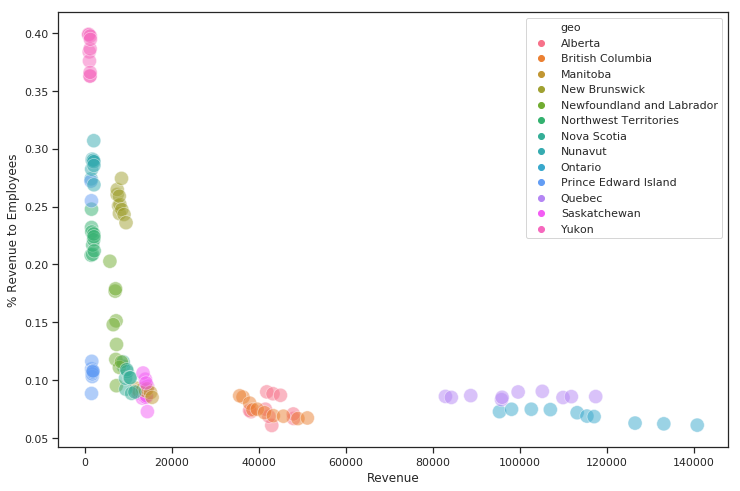

In [169]:
figure(figsize=(12, 8))
ax = sns.scatterplot(x="Revenue", y="% Revenue to Employees", hue="geo", data=dd, s=200, alpha=0.5)
# ax.set_xscale('log')

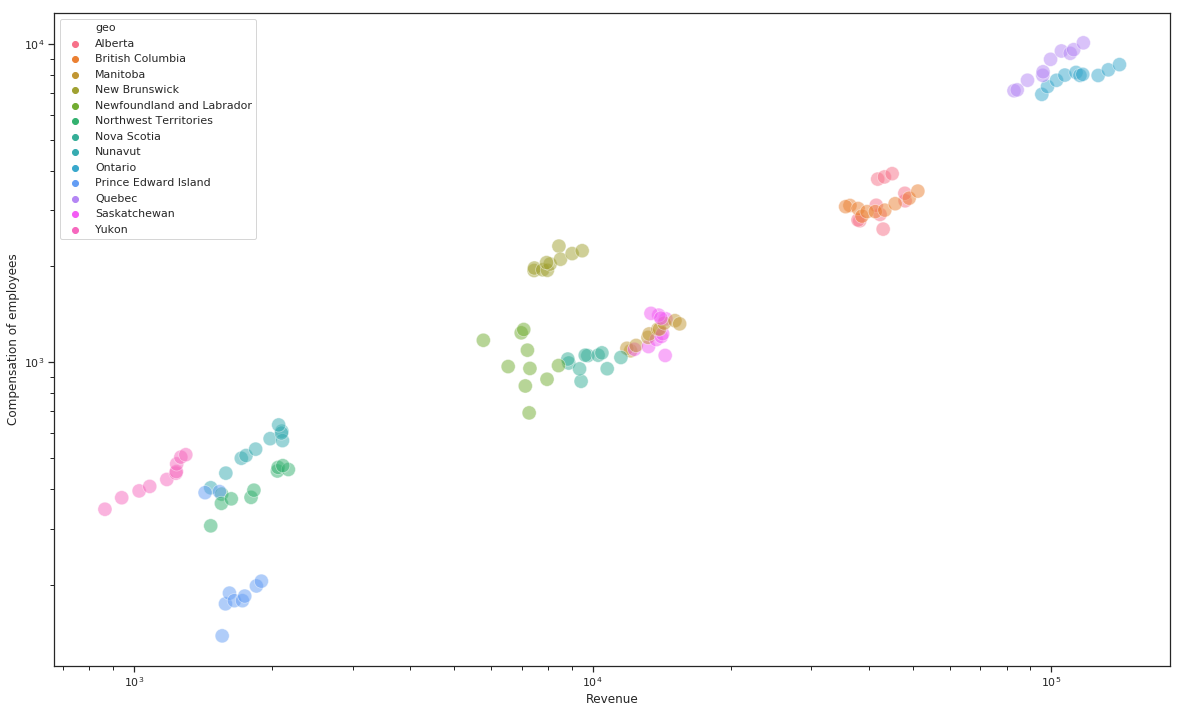

In [158]:
%matplotlib inline
dd = d.reset_index()
from pylab import *
figure(figsize=(20, 12))
ax = sns.scatterplot(x="Revenue", y="Compensation of employees", hue="geo", data=dd, s=200, alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')

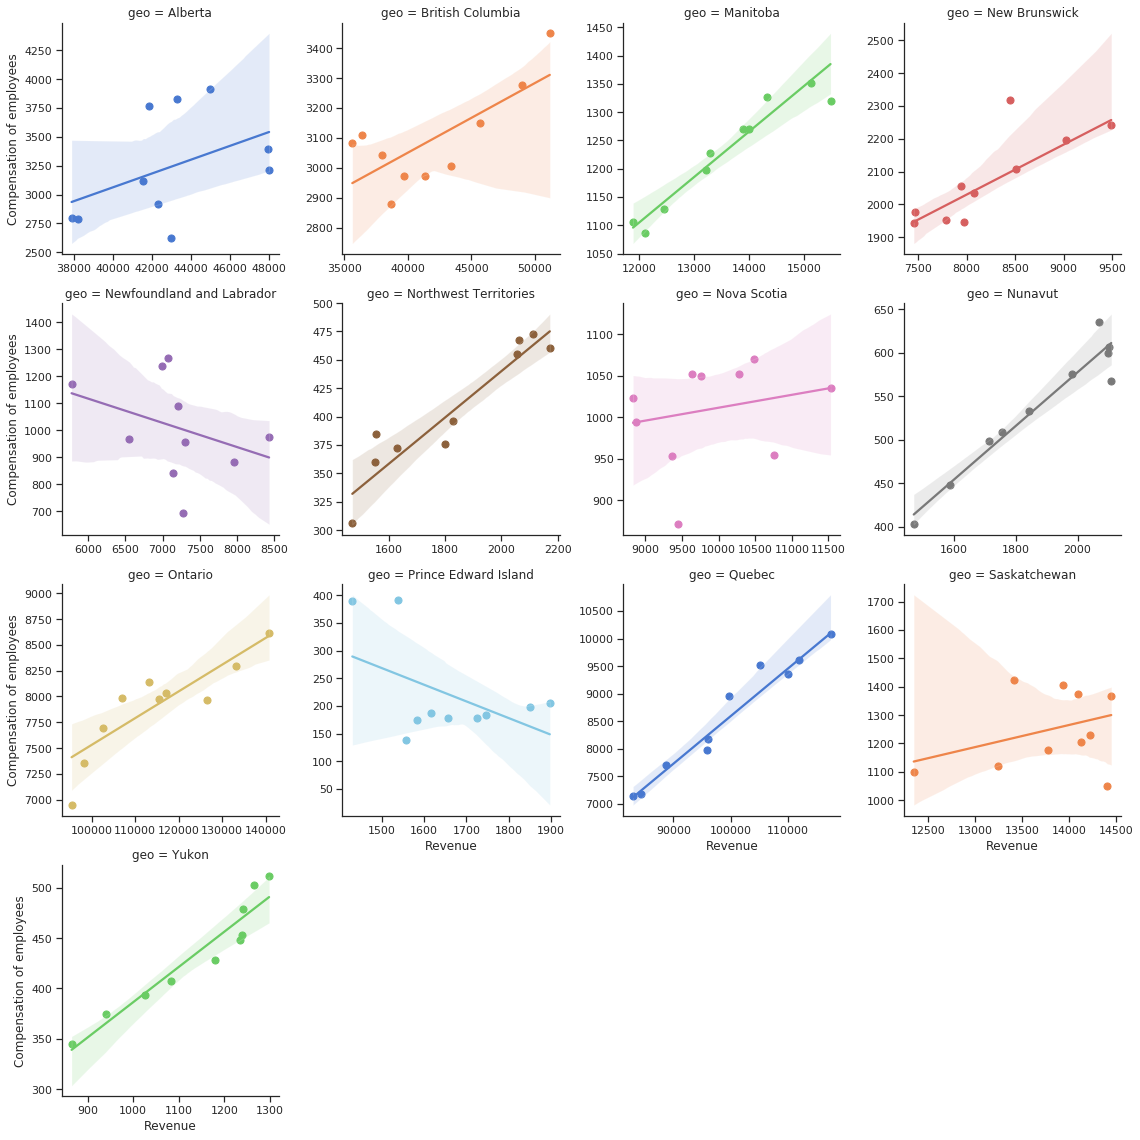

In [149]:
ax = sns.lmplot(x="Revenue", y="Compensation of employees", hue="geo",
                col="geo", data=dd, col_wrap=4, truncate=True, sharex=False, sharey=False,
                palette="muted", height=4,
                scatter_kws={"s": 50, "alpha": 1}, robust=True,
                order=1)